# Conditional Normalizing Flow Model

Here, we train a conditional normalizing flow model $q(x|c)$. Our target $p(x|c)$ is a simple 2D Gaussian $\mathcal{N}(x|\mu, \sigma)$, where we condition on the mean $\mu$ and standard deviation $\sigma$, i.e. $c = (\mu, \sigma)$. We apply conditional autoregressive and coupling neural spline flows as well as a conditional masked autoregressive flow to the problem.

## Workflow
0. Before working in this notebook, you must first run simulations and the preprocess the data as it takes way too long to do interactively.
    1. For simulating data, see work_eic/slurm/makeJobs*
    1. for preprocessing the data see work_eic/macros/Time_estimation/slurm/
    1. These use the slurm batch system to run on the dcc
    1. Once you have run these, you should have a few .pt files that contain tensors that can be read into this notebook
    1. These tensors should have 5 values, the first four being context and the last being the time value which is the feature
1. Load in the data and shuffle it to ensure data is randomly distributed in dataset; then separate into train and test sets
2. Define model
    1. Right now the autoregressive neural spline model seems to work well
    1. We have used masked affine coupling models before in the past but this doesn't seem like it would make sense here as we only have 1 feature and hence cannot mask it
3. Train the model with the training loop (unless you already have a pretrained model)
4. Save the model (or load)
5. Generate samples based on the context of your test dataset
6. Plot timing distribution
    7. The test distribution should match the sampled distribution pretty well since the samples are drawn from the same context as the test data

## Setup

In [1]:
# Import packages
import torch
import numpy as np
import normflows as nf

import uproot as up

from matplotlib import pyplot as plot
import math
from tqdm import tqdm
from util import PVect, theta_func, r_func
from IPython.display import clear_output


Using device cuda:0


In [2]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Data preparation
Need 5 features:
1. Four conditionals:
    1. Hit z position (calculate from shoot position and angle)
    2. mu incident time on scint (calculate from momentum and distance)
    3. hit theta (calculate from momentum vector)
    4. hit momenta (calculate from momentum vector)
2. Feature
    1. photon hit time on sensor

##### Status
1. Hit z, hit theta, hit momenta and photon hit time are all good
1. Just need to calculate hit time from momentum (velocity) and distance traveled (use pythogorean theorem with x and z)

### Preprocess manually below if not loading data

### Load data from .pt file (created by preprocess.py)

In [17]:
# Timing_path = "/cwork/rck32/eic/work_eic/macros/Timing_estimation/"

# inputs = torch.load(Timing_path + "data/July_04/Run_0/Vary_p_2000events_file_0_w_cuts.pt")
# for i in range(1,18):
#     inputs = torch.cat((inputs, torch.load(Timing_path + f"data/July_04/Run_0/Vary_p_2000events_file_{i}_w_cuts.pt")),0)

In [3]:
Timing_path = "/cwork/rck32/eic/work_eic/macros/Timing_estimation/"

inputs = torch.load(Timing_path + "data/July_05/Run_0/Vary_p_2000events_file_0_July_5_50_z_pos.pt")
for i in range(1,51):
    inputs = torch.cat((inputs, torch.load(Timing_path + f"data/July_05/Run_0/Vary_p_2000events_file_{i}_July_5_50_z_pos.pt")),0)

In [4]:
inputs.shape

torch.Size([78946521, 5])

In [35]:
# '''
# Constant p
# '''

# inputs = torch.load("data/July_03/Run_0/Full_4000events_file_0_w_cuts.pt")
# for i in range(1,16):
#     inputs = torch.cat((inputs, torch.load(f"data/July_03/Run_0/Full_4000events_file_{i}_w_cuts.pt")),0)

In [36]:
# fig, axs = plot.subplots(4,2,figsize = (12,20))
# fig.suptitle("inputs 50 z vals")
# axs[0,0].hist(inputs[:,0],bins = 500);
# axs[0,0].set_title("hit z pos")
# axs[0,0].set_xlabel("mm")
# axs[0,1].hist(inputs[:,1],bins = 100)
# axs[0,1].set_title("mu hit incident time")
# axs[0,1].set_xlabel("(ns)")

# axs[1,0].hist(inputs[:,2],bins = 500);
# axs[1,0].set_title("gun theta")
# axs[1,0].set_xlabel("theta (degrees)")
# axs[1,1].hist(inputs[:,4],bins = 500);
# axs[1,1].set_title("photon hit time on sensor")
# axs[1,1].set_xlabel("(ns)")

# axs[2,0].hist2d(inputs[:,2],inputs[:,1],bins = 500);
# axs[2,0].set_title("theta vs mu hit incident time")
# axs[2,0].set_xlabel("theta")
# axs[2,0].set_ylabel("mu hit incident time")
# axs[2,1].hist2d(inputs[:,0], inputs[:,4],bins = 500);
# axs[2,1].set_title("photon hit time on sensor vs z hit position")
# axs[2,1].set_xlabel("z hit pos (mm)")
# axs[2,1].set_ylabel("photon hit time on sensor (ns)")

# axs[3,0].hist(inputs[:,3],bins = 500);
# axs[3,0].set_title("mu momentum")
# axs[3,0].set_xlabel("momentum (GeV/c)")

In [37]:
# fig.savefig("plots/inputs/inputs_vary_p_50_z_vals.pdf")

In [5]:
indexes = torch.randperm(inputs.shape[0])
dataset = inputs[indexes]
train_frac = 0.8
train_lim = int(np.floor(dataset.shape[0] * train_frac))
train_data = dataset[:train_lim]
test_data = dataset[train_lim:]

In [6]:
test_data.shape

torch.Size([15789305, 5])

## Masked Autoregressive Flow

### Model specification

In [72]:
# # Define flows
# K = 4

# latent_size = 1
# hidden_units = 128
# num_blocks = 2
# context_size = 4

# flows = []
# for i in range(K):
#     flows += [nf.flows.MaskedAffineAutoregressive(latent_size, hidden_units, 
#                                                   context_features=context_size, 
#                                                   num_blocks=num_blocks)]
#     flows += [nf.flows.LULinearPermute(latent_size)]

# # Set base distribution
# q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# # Construct flow model
# model = nf.ConditionalNormalizingFlow(q0, flows)

# # Move model on GPU if available
# model = model.to(device)

## Neural Spline Flow

In [7]:
# Define flows
K = 6

latent_size = 1
hidden_units = 100
hidden_layers = 4
context_size = 4
num_context = 4
K_str = str(K)
batch_size= 4000
hidden_units_str = str(hidden_units)
hidden_layers_str = str(hidden_layers)
batch_size_str = str(batch_size)
flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)


### Training

In [8]:
# Train model

num_context = 4
num_epochs = 5
max_iter = int(np.floor(train_data.shape[0] / batch_size))

loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
for epoch in range(num_epochs):
    print(f"Beginning epoch #{epoch}")
    for it in tqdm(range(max_iter)):
        optimizer.zero_grad()

        # Get training samples
        begin = it * batch_size
        end = (it + 1) * batch_size
        it_data = train_data[begin:end]
        context = it_data[:,:num_context].to(device)
        samples = it_data[:,num_context].unsqueeze(1).to(device)

        # Compute loss
        loss = model.forward_kld(samples, context)

        # Do backprop and optimizer step
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()

        # Log loss
        loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

Beginning epoch #0


100%|██████████| 15789/15789 [14:51<00:00, 17.72it/s]


Beginning epoch #1


100%|██████████| 15789/15789 [14:54<00:00, 17.66it/s]


Beginning epoch #2


100%|██████████| 15789/15789 [15:00<00:00, 17.54it/s]


Beginning epoch #3


100%|██████████| 15789/15789 [15:01<00:00, 17.52it/s]


Beginning epoch #4


100%|██████████| 15789/15789 [14:56<00:00, 17.60it/s]


In [9]:
model.save("models/July_11/run_5_" + K_str + "flows_" + hidden_layers_str + "hl_" + hidden_units_str + "hu_" + batch_size_str + "bs.pth")

# model.load("models/July_4/vary_p_uniform_12_flows_8hl_64hu_100bs.pth")

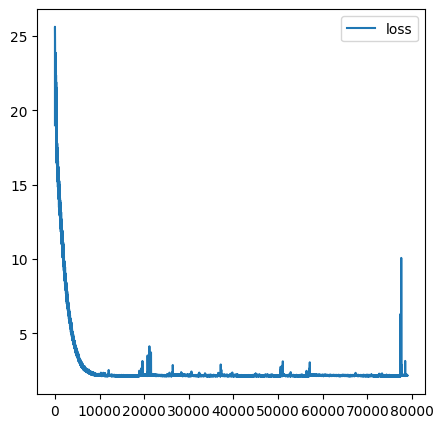

In [10]:
# Plot loss
plot.figure(figsize=(5, 5))
plot.plot(loss_hist, label='loss')
plot.savefig("plots/loss/July_11/run_5.jpeg")
plot.legend()
plot.show()

In [11]:
torch.save(test_data, "data/test/July_11/full_test_data_run_5_"+ K_str + "flows_" + hidden_layers_str + "hl_" + hidden_units_str + "hu_" + batch_size_str + "bs.pt")

### Evaluation

In [ ]:
min_time = min(inputs[:,4])
skipped = np.array([])

eval_batch_size = 1000
eval_max_iter = test_data.shape[0] // eval_batch_size
eval_test_data = test_data[:eval_max_iter * eval_batch_size]

eval_test_data.to('cpu')
model.to('cpu')
model.eval()
samples = torch.empty(eval_test_data.shape[0])
for i in tqdm(range(eval_max_iter)):
    begin = eval_batch_size * i
    end = eval_batch_size * (i + 1)
    samples[begin:end] = model.sample(num_samples = eval_batch_size, context = test_data[begin:end,:num_context])[0].cpu().detach().squeeze(1)
    

In [ ]:
for i in range(len(samples)):
    if(samples[i] < min_time):
        skipped = np.append(skipped, i)
for i in range(len(skipped) - 1):
    samples = torch.cat((samples[:int(skipped[i])],samples[int(skipped[i] + 1):int(skipped[i + 1])]))
model.train();

### Claude code no resampling, cut

In [30]:
min_time = min(inputs[:, 4])
eval_batch_size = 1000
eval_max_iter = test_data.shape[0] // eval_batch_size
eval_test_data = test_data[:eval_max_iter * eval_batch_size].to('cpu')
model.to('cpu')
model.eval()

samples = []
total_samples = 0
target_samples = eval_test_data.shape[0]

with torch.no_grad():
    pbar = tqdm(total=target_samples)
    while total_samples < target_samples:
        remaining = target_samples - total_samples
        batch_size = min(eval_batch_size, remaining)
        
        batch_samples = model.sample(num_samples=batch_size, 
                                     context=eval_test_data[total_samples:total_samples+batch_size, :num_context])[0]
        
        valid_samples = batch_samples[batch_samples.squeeze(1) >= min_time]
        samples.append(valid_samples)
        
        new_samples = valid_samples.shape[0]
        total_samples += new_samples
        pbar.update(new_samples)

    pbar.close()

samples = torch.cat(samples, dim=0)[:target_samples].squeeze(1)
model.train();

KeyboardInterrupt: 

### Claude code resampling, cut

In [ ]:
min_time = min(inputs[:, 4])
eval_batch_size = 1000
eval_max_iter = test_data.shape[0] // eval_batch_size
eval_test_data = test_data[:eval_max_iter * eval_batch_size].to('cpu')
model.to('cpu')
model.eval()

samples = torch.empty(eval_test_data.shape[0], 1)

with torch.no_grad():
    for i in tqdm(range(eval_max_iter)):
        begin = eval_batch_size * i
        end = eval_batch_size * (i + 1)
        batch_context = eval_test_data[begin:end, :num_context]
        
        batch_samples = model.sample(num_samples=eval_batch_size, context=batch_context)[0]
        valid_mask = batch_samples.squeeze(1) >= min_time
        
        while not valid_mask.all():
            invalid_indices = torch.where(~valid_mask)[0]
            resampled = model.sample(num_samples=len(invalid_indices), 
                                     context=batch_context[invalid_indices])[0]
            batch_samples[invalid_indices] = resampled
            valid_mask[invalid_indices] = resampled.squeeze(1) >= min_time
        
        samples[begin:end] = batch_samples
samples = samples.squeeze(1)
model.train();

In [3]:
# torch.save(samples,"data/samples/vary_p_uniform_6_hl_100_bs.pt")
# torch.save(eval_test_data,"data/test/vary_p_uniform_6_hl_100_bs.pt")

samples = torch.load("data/samples/vary_p_uniform_12_flows_8hl_64hu_100bs.pt")
eval_test_data = torch.load("data/test/vary_p_uniform_12_flows_8hl_64hu_100bs.pt")

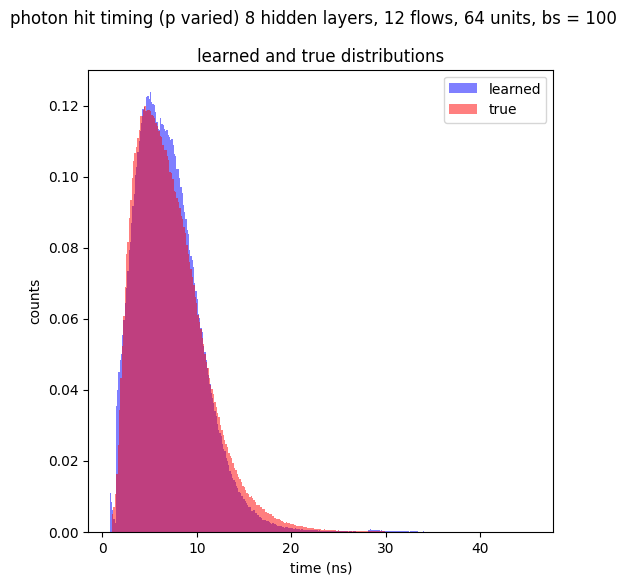

In [49]:
sample_fig, sample_axs = plot.subplots(1,1,figsize=(6,6))
sample_fig.suptitle("photon hit timing (p varied) 8 hidden layers, 12 flows, 64 units, bs = 100")
sample_axs.hist(samples,bins = 300, alpha = 0.5,color = 'b', label = 'learned', density = True)
sample_axs.set_title("learned and true distributions")
sample_axs.set_xlabel("time (ns)")
sample_axs.set_ylabel("counts")
sample_axs.hist(eval_test_data[:,num_context],bins = 300, color = 'r', alpha = 0.5, label = 'true', density = True)
sample_axs.legend(loc='upper right')
sample_fig.show()

In [50]:
sample_fig.savefig("plots/test_distributions/vary_p_uniform_12_flows_8hl_64hu_100bs_normalized_resample.pdf")